<a href="https://colab.research.google.com/github/nhyunaa/2025-1_CV/blob/main/CV_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#실험C

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.0MB/s]



=== Training with SGD_lr0.1 ===
SGD (lr=0.1) Epoch 1/30 - Loss: 0.6223, Acc: 0.8126
SGD (lr=0.1) Epoch 2/30 - Loss: 0.4007, Acc: 0.8465
SGD (lr=0.1) Epoch 3/30 - Loss: 0.3499, Acc: 0.8377
SGD (lr=0.1) Epoch 4/30 - Loss: 0.3207, Acc: 0.8680
SGD (lr=0.1) Epoch 5/30 - Loss: 0.2960, Acc: 0.8711
SGD (lr=0.1) Epoch 6/30 - Loss: 0.2770, Acc: 0.8727
SGD (lr=0.1) Epoch 7/30 - Loss: 0.2588, Acc: 0.8738
SGD (lr=0.1) Epoch 8/30 - Loss: 0.2445, Acc: 0.8798
SGD (lr=0.1) Epoch 9/30 - Loss: 0.2309, Acc: 0.8794
SGD (lr=0.1) Epoch 10/30 - Loss: 0.2185, Acc: 0.8852
SGD (lr=0.1) Epoch 11/30 - Loss: 0.2071, Acc: 0.8858
SGD (lr=0.1) Epoch 12/30 - Loss: 0.1960, Acc: 0.8847
SGD (lr=0.1) Epoch 13/30 - Loss: 0.1862, Acc: 0.8686
SGD (lr=0.1) Epoch 14/30 - Loss: 0.1770, Acc: 0.8939
SGD (lr=0.1) Epoch 15/30 - Loss: 0.1687, Acc: 0.8751
SGD (lr=0.1) Epoch 16/30 - Loss: 0.1605, Acc: 0.8943
SGD (lr=0.1) Epoch 17/30 - Loss: 0.1529, Acc: 0.8918
SGD (lr=0.1) Epoch 18/30 - Loss: 0.1457, Acc: 0.8942
SGD (lr=0.1) Epoch 19/

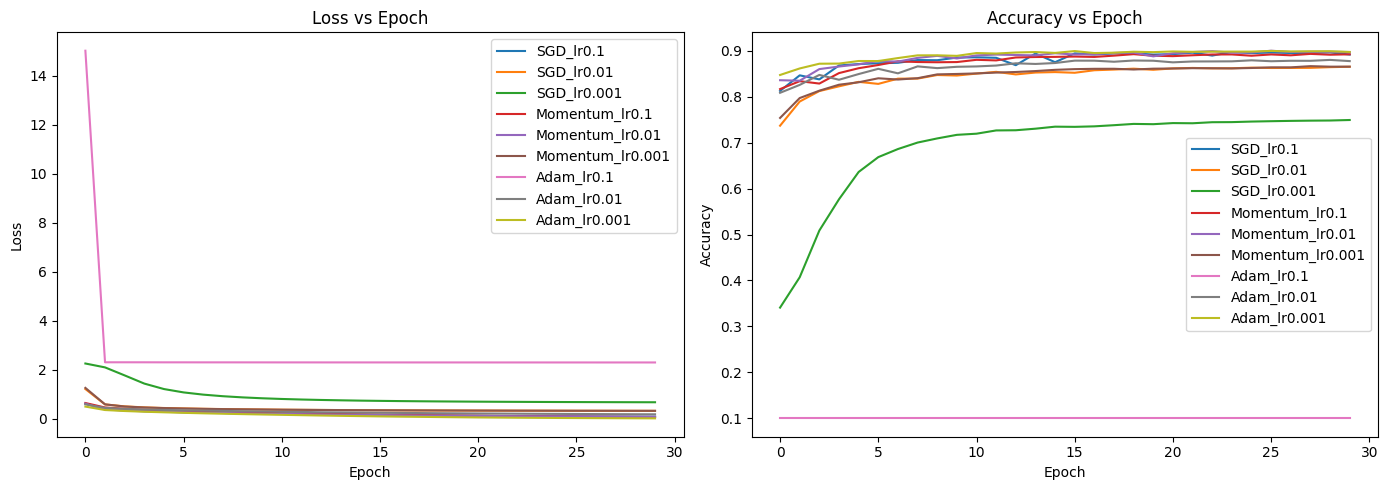

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Seed 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# 하이퍼파라미터 설정
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATES = [0.1, 0.01, 0.001]

# 데이터셋 (FashionMNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 더 깊은 MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),  # 입력
            nn.ReLU(),
            nn.Linear(512, 256),    # 두 번째 은닉층
            nn.ReLU(),
            nn.Linear(256, 128),    # 세 번째 은닉층
            nn.ReLU(),
            nn.Linear(128, 10)      # 출력층
        )
    def forward(self, x):
        return self.net(x)

#  평가 함수
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            output = model(x)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# 학습 루프
def train_model(optimizer_name, lr):
    model = MLP()
    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    train_losses, test_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        acc = evaluate(model, test_loader)
        test_accuracies.append(acc)
        scheduler.step()
        print(f"{optimizer_name} (lr={lr}) Epoch {epoch+1}/{EPOCHS} - Loss: {train_losses[-1]:.4f}, Acc: {acc:.4f}")

    return train_losses, test_accuracies

# 실험 실행
results = {}
for opt in ['SGD', 'Momentum', 'Adam']:
    for lr in LEARNING_RATES:
        key = f'{opt}_lr{lr}'
        print(f"\n=== Training with {key} ===")
        losses, accs = train_model(opt, lr)
        results[key] = {'loss': losses, 'acc': accs}

#  결과 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for key in results:
    plt.plot(results[key]['loss'], label=f"{key}")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for key in results:
    plt.plot(results[key]['acc'], label=f"{key}")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
